In [1]:
import pandas as pd
import librosa
import os
import numpy as np
import seaborn as sns
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchaudio
import torchaudio.transforms as T


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
CREMAD="/content/drive/MyDrive/Datasets/Audio Datasets/Crema"
SAVE="/content/drive/MyDrive/Datasets/Audio Datasets/Savee"
RAVDESS="/content/drive/MyDrive/Datasets/Audio Datasets/Ravdess/audio_speech_actors_01-24"
TESS= "/content/drive/MyDrive/Datasets/Audio Datasets/Tess"



In [4]:
audios = pd.DataFrame(data=[], columns=['Dataset', 'Path', "File", "Emotion"])
audios

Empty DataFrame
Columns: [Dataset, Path, File, Emotion]
Index: []

## Adding CREMA Dataset to DataFrame

SAD - sadness;
ANG - angry;
DIS - disgust;
FEA - fear;
HAP - happy;
NEU - neutral.

In [5]:
emotion_map_crema = {
    "DIS": "Disgust",
    "SAD": "Sad",
    "HAP": "Happy",
    "NEU": "Neutral",
    "FEA": "Fearful",
    "ANG": "Angry"
    }

In [6]:
def process_file(file):
    emotion = emotion_map_crema[file.split("_")[2]]

    return {
        "Dataset": "CREMA-D",
        "Path": os.path.join(CREMAD, file),
        "File": os.path.splitext(file)[0],
        "Emotion": emotion
        }

files = Parallel(n_jobs=-1, verbose=5)(
    delayed(process_file)(file) for file in os.listdir(CREMAD)
)
audios = pd.concat((audios, pd.DataFrame(files)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 772 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 7442 out of 7442 | elapsed:    0.5s finished


## Adding SAVE Dataset to DataFrame

'a' = 'anger',
'd' = 'disgust',
'f' = 'fear',
'h' = 'happiness',
'n' = 'neutral',
'sa' = 'sadness',
'su' = 'surprise'

In [7]:
emotion_map_save = {
    'a': "Angry",
    'd': "Disgust",
    'f': "Fearful",
    'h': "Happy",
    'n': "Neutral",
    'sa': "Sad",
    }

In [8]:
print("SAVE path exists:", os.path.exists(SAVE))
print("SAVE sample files:", os.listdir(SAVE)[:5])


SAVE path exists: True
SAVE sample files: ['DC_d08.wav', 'DC_a03.wav', 'DC_a13.wav', 'DC_d13.wav', 'DC_d03.wav']


In [9]:
for file in os.listdir(SAVE):
    if not file.endswith(".wav"):
        continue

    base = os.path.splitext(file)[0]
    code = base.split("_")[1].lower()


    emotion_code = code[:2] if code[:2] in emotion_map_save else code[0]

    emotion = emotion_map_save.get(emotion_code)

    if emotion:
        full_path = os.path.join(SAVE, file)
        audios.loc[len(audios)] = {
            "Dataset": "SAVEE",
            "Path": full_path,
            "File": base,
            "Emotion": emotion
        }
        print(f" Added: {file} → {emotion}")
    else:
        print(f"Skipped: {file} — unknown emotion code: {emotion_code}")


 Added: DC_d08.wav → Disgust
 Added: DC_a03.wav → Angry
 Added: DC_a13.wav → Angry
 Added: DC_d13.wav → Disgust
 Added: DC_d03.wav → Disgust
 Added: DC_f02.wav → Fearful
 Added: DC_a07.wav → Angry
 Added: DC_a06.wav → Angry
 Added: DC_a12.wav → Angry
 Added: DC_a09.wav → Angry
 Added: DC_d09.wav → Disgust
 Added: DC_d12.wav → Disgust
 Added: DC_d04.wav → Disgust
 Added: DC_a14.wav → Angry
 Added: DC_f01.wav → Fearful
 Added: DC_d14.wav → Disgust
 Added: DC_d15.wav → Disgust
 Added: DC_a02.wav → Angry
 Added: DC_d07.wav → Disgust
 Added: DC_d05.wav → Disgust
 Added: DC_d06.wav → Disgust
 Added: DC_d10.wav → Disgust
 Added: DC_a11.wav → Angry
 Added: DC_a08.wav → Angry
 Added: DC_a04.wav → Angry
 Added: DC_d11.wav → Disgust
 Added: DC_d01.wav → Disgust
 Added: DC_d02.wav → Disgust
 Added: DC_f03.wav → Fearful
 Added: DC_a05.wav → Angry
 Added: DC_a01.wav → Angry
 Added: DC_a15.wav → Angry
 Added: DC_a10.wav → Angry
 Added: DC_h10.wav → Happy
 Added: DC_n13.wav → Neutral
 Added: DC_h01.wa

## Adding RAVDESS Dataset to DataFrame

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

In [10]:
emotion_map_ravdess = {
    1: "Neutral",
    3: "Happy",
    4: "Sad",
    5: "Angry",
    6: "Fearful",
    7: "Disgust",
    }


In [11]:
for folder in os.listdir(RAVDESS):
    folder_path = os.path.join(RAVDESS, folder)
    if not os.path.isdir(folder_path):
        continue

    for file in os.listdir(folder_path):
        if not file.endswith(".wav"):
            continue

        parts = file.split("-")
        if len(parts) < 3:
            print(f" Skipping file with unexpected name: {file}")
            continue

        try:
            emotion_id = int(parts[2])
        except ValueError:
            print(f" Invalid emotion ID in file: {file}")
            continue

        emotion = emotion_map_ravdess.get(emotion_id)

        if emotion:
            full_path = os.path.join(folder_path, file)
            audios.loc[len(audios)] = {
                "Dataset": "RAVDESS",
                "Path": full_path,
                "File": os.path.splitext(file)[0],
                "Emotion": emotion
            }
            print(f" Added: {file} → {emotion}")
        else:
            print(f" Skipped: {file} — emotion ID not in use: {emotion_id}")


 Added: 03-01-01-01-02-01-04.wav → Neutral
 Skipped: 03-01-02-01-02-02-04.wav — emotion ID not in use: 2
 Added: 03-01-06-01-02-01-04.wav → Fearful
 Added: 03-01-05-01-01-01-04.wav → Angry
 Added: 03-01-04-01-02-01-04.wav → Sad
 Skipped: 03-01-02-01-02-01-04.wav — emotion ID not in use: 2
 Added: 03-01-04-02-01-02-04.wav → Sad
 Added: 03-01-05-02-02-02-04.wav → Angry
 Added: 03-01-05-02-01-02-04.wav → Angry
 Added: 03-01-06-01-01-02-04.wav → Fearful
 Skipped: 03-01-02-02-01-01-04.wav — emotion ID not in use: 2
 Skipped: 03-01-02-02-01-02-04.wav — emotion ID not in use: 2
 Added: 03-01-03-02-02-02-04.wav → Happy
 Added: 03-01-06-01-02-02-04.wav → Fearful
 Added: 03-01-04-01-01-02-04.wav → Sad
 Added: 03-01-01-01-02-02-04.wav → Neutral
 Added: 03-01-04-01-02-02-04.wav → Sad
 Added: 03-01-04-02-01-01-04.wav → Sad
 Added: 03-01-04-01-01-01-04.wav → Sad
 Added: 03-01-03-01-01-01-04.wav → Happy
 Added: 03-01-05-01-02-02-04.wav → Angry
 Added: 03-01-04-02-02-01-04.wav → Sad
 Added: 03-01-04-0

## Adding TESS Dataset to DataFrame

In [12]:
emotion_map_tess = {
    "ANGRY": "Angry",
    "DISGUST": "Disgust",
    "FEAR": "Fearful",
    "HAPPY": "Happy",
    "NEUTRAL": "Neutral",
    "SAD": "Sad",
}


In [13]:
for folder in os.listdir(TESS):
    folder_path = os.path.join(TESS, folder)
    if not os.path.isdir(folder_path):
        continue

    for file in os.listdir(folder_path):
        if not file.endswith(".wav"):
            continue

        parts = file.split("_")
        if len(parts) < 3:
            print(f" Skipping malformed file: {file}")
            continue


        emotion_code = parts[2].split(".")[0].upper()
        emotion = emotion_map_tess.get(emotion_code)

        if emotion:
            full_path = os.path.join(folder_path, file)
            audios.loc[len(audios)] = {
                "Dataset": "TESS",
                "Path": full_path,
                "File": os.path.splitext(file)[0],
                "Emotion": emotion
            }
            print(f"Added: {file} → {emotion}")
        else:
            print(f"Skipped: {file} — unknown emotion: {emotion_code}")


Added: OAF_burn_disgust.wav → Disgust
Added: OAF_choice_disgust.wav → Disgust
Added: OAF_base_disgust.wav → Disgust
Added: OAF_check_disgust.wav → Disgust
Added: OAF_dab_disgust.wav → Disgust
Added: OAF_dog_disgust.wav → Disgust
Added: OAF_came_disgust.wav → Disgust
Added: OAF_bite_disgust.wav → Disgust
Added: OAF_beg_disgust.wav → Disgust
Added: OAF_chalk_disgust.wav → Disgust
Added: OAF_ditch_disgust.wav → Disgust
Added: OAF_dip_disgust.wav → Disgust
Added: OAF_dime_disgust.wav → Disgust
Added: OAF_deep_disgust.wav → Disgust
Added: OAF_doll_disgust.wav → Disgust
Added: OAF_bought_disgust.wav → Disgust
Added: OAF_cheek_disgust.wav → Disgust
Added: OAF_cool_disgust.wav → Disgust
Added: OAF_door_disgust.wav → Disgust
Added: OAF_fall_disgust.wav → Disgust
Added: OAF_cab_disgust.wav → Disgust
Added: OAF_fail_disgust.wav → Disgust
Added: OAF_death_disgust.wav → Disgust
Added: OAF_bean_disgust.wav → Disgust
Added: OAF_book_disgust.wav → Disgust
Added: OAF_bone_disgust.wav → Disgust
Added: O

# EDA

In [14]:
audios

Dataset                                               Path  \
0      CREMA-D  /content/drive/MyDrive/Datasets/Audio Datasets...   
1      CREMA-D  /content/drive/MyDrive/Datasets/Audio Datasets...   
2      CREMA-D  /content/drive/MyDrive/Datasets/Audio Datasets...   
3      CREMA-D  /content/drive/MyDrive/Datasets/Audio Datasets...   
4      CREMA-D  /content/drive/MyDrive/Datasets/Audio Datasets...   
...        ...                                                ...   
11320     TESS  /content/drive/MyDrive/Datasets/Audio Datasets...   
11321     TESS  /content/drive/MyDrive/Datasets/Audio Datasets...   
11322     TESS  /content/drive/MyDrive/Datasets/Audio Datasets...   
11323     TESS  /content/drive/MyDrive/Datasets/Audio Datasets...   
11324     TESS  /content/drive/MyDrive/Datasets/Audio Datasets...   

                  File  Emotion  
0      1079_IWW_DIS_XX  Disgust  
1      1079_TIE_DIS_XX  Disgust  
2      1080_IOM_FEA_XX  Fearful  
3      1080_TAI_NEU_XX  Neutral  
4      1079_TAI_SAD_XX      Sad  
...                ...      ...  
11320     YAF_time_sad      Sad  
11321    YAF_thumb_sad      Sad  
11322     YAF_wash_sad      Sad  
11323     YAF_whip_sad      Sad  
11324     YAF_walk_sad      Sad  

[11325 rows x 4 columns]

In [15]:
audios.Dataset.unique()

array(['CREMA-D', 'SAVEE', 'RAVDESS', 'TESS'], dtype=object)

In [16]:
print("Total audio files:", len(audios))

Total audio files: 11325


In [17]:
print(audios['Dataset'].value_counts())

Dataset
CREMA-D    7442
TESS       2400
RAVDESS    1063
SAVEE       420
Name: count, dtype: int64


<Axes: ylabel='count'>

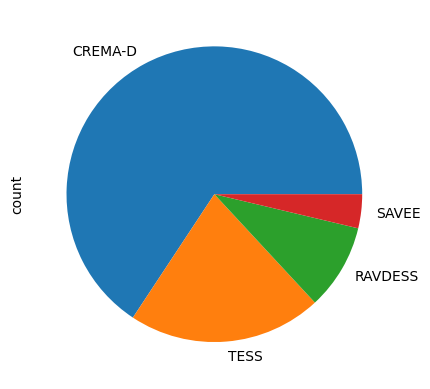

In [18]:
audios.Dataset.value_counts().plot.pie()

In [19]:
audios.Emotion.unique()

array(['Disgust', 'Fearful', 'Neutral', 'Sad', 'Happy', 'Angry'],
      dtype=object)

<Axes: xlabel='Emotion'>

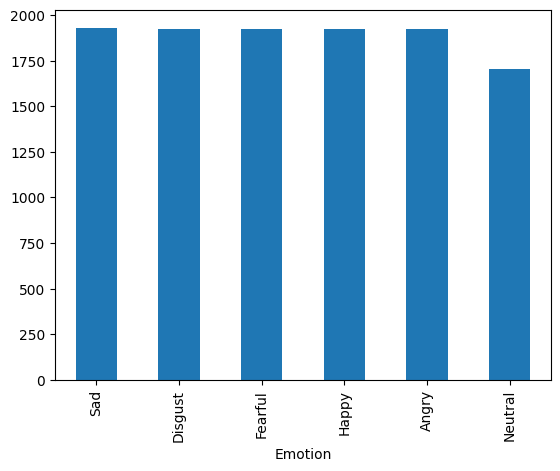

In [20]:
audios.Emotion.value_counts().plot(kind='bar')

# Feature Extraction

In [21]:
!pip install pyloudnorm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 9.1 MB/s eta 0:00:00


In [22]:
import pyloudnorm as pyln
import IPython.display as ipd

Initializing a loudness meter to compute LUFS( Loudness Units relative to Full Scale) to measure how loud a sound seems to humans

In [23]:
meter = pyln.Meter(22050)

SNR (Signal-to-Noise Ratio) a metric that tells us how much the audio is actual signal vs. background noise


*   Higher SNR = clearer audio, less noise.
*   Lower SNR = noisier or lower-quality audio.



In [24]:
def estimate_snr(y):
    signal_power = np.mean(y**2)
    noise_power = np.var(y - np.mean(y))
    return 10 * np.log10(signal_power / (noise_power + 1e-12))


Compute 7 key audio features:
duration: length of audio in seconds,
sample_rate: samples per second,
loudness: LUFS,
rms: Root mean square energy ( signal strength),
peak: maximum amplitude,
signal to noise ratio: quality of audio,
percentage of samples with silence: silence detection

In [25]:
def process_file(idx, row, meter):
    audio_path = row['Path']
    try:
        y, sr = librosa.load(audio_path)
        duration = librosa.get_duration(y=y, sr=sr)
        loudness = meter.integrated_loudness(y)
        rms = np.sqrt(np.mean(y**2))
        peak = np.max(np.abs(y))
        signal_to_noise = estimate_snr(y)
        silence_pct = np.sum(np.abs(y) < 0.001) / len(y)

        return {
            "ID": idx,
            'path': audio_path,
            "dataset": row['Dataset'],
            'duration': duration,
            'sample_rate': sr,
            'loudness': loudness,
            'rms': rms,
            'peak': peak,
            "signal_to_noise": signal_to_noise,
            "silence_pct": silence_pct,
            'emotion': row['Emotion']
        }
    except Exception as e:
        print(f" Error processing {audio_path}: {e}")
        return idx

In [26]:
def get_info(df, sample_size=5, meter=meter):

    print("Verifying audio files...")
    # Step1: Processing files in parallel
    results = Parallel(n_jobs=-1)(
        delayed(process_file)(idx, row, meter) for idx, row in tqdm(df.iterrows(), total=len(df), desc="Checking audio files")
    )
    #Step 2: Separate Valid and Invalid Files
    audio_info = [r for r in results if type(r) == dict]
    invalid_files = [r for r in results if type(r) != dict]

    print(f" Valid files: {len(audio_info)}")
    print(f" Invalid files: {len(invalid_files)}")

    # Step 4: Feature Analysis and Visualization
    if len(audio_info) == 0:
        print(" No valid audio files found.")
        return

    # Plot distributions
    if len(audio_info) > 1:
        sr_df = pd.DataFrame(audio_info)
        print(f"Length of DataFrame: {len(sr_df)}")

        plt.figure(figsize=(10, 10))

        # Sample Rate Distribution
        plt.subplot(3, 3, 1)
        sr_df['sample_rate'].hist(bins=20, alpha=0.7, color='lightcoral')
        plt.title('Sample Rate Distribution')
        plt.xlabel('Sample Rate (Hz)')
        plt.ylabel('Count')

        # Duration Distribution
        plt.subplot(3, 3, 2)
        sr_df['duration'].hist(bins=20, alpha=0.7, color='lightgreen')
        plt.title('Audio Duration Distribution')
        plt.xlabel('Duration (seconds)')
        plt.ylabel('Count')

        try:
            # pyln Loudness Distribution
            plt.subplot(3, 3, 3)
            sr_df['loudness'].hist(bins=20, alpha=0.7, color='red')
            plt.title('LUFS Loudness Distribution')
            plt.xlabel('Loudness (dB)')
            plt.ylabel('Count')
        except Exception as e:
            print("Exception occured while displaying the loudness Distribution chart:", str(e))

        # RMS Value Distribution
        plt.subplot(3, 3, 4)
        sr_df['rms'].hist(bins=20, alpha=0.7, color='lightpink')
        plt.title('RMS Perceptual Energy Distribution')
        plt.xlabel('Energy Value')
        plt.ylabel('Count')

        # Peak Value Distribution
        plt.subplot(3, 3, 5)
        sr_df['peak'].hist(bins=20, alpha=0.7, color='darkgreen')
        plt.title('Peak Distribution')
        plt.xlabel('Energy Value')
        plt.ylabel('Count')

        # Silence Distribution
        plt.subplot(3, 3, 6)
        sr_df['silence_pct'].hist(bins=20, alpha=0.7, color='purple')
        plt.title('Silence Distribution')
        plt.xlabel('Silence %')
        plt.ylabel('Count')

        # Signal-to-Noise Distribution
        try:
            plt.subplot(3, 3, 7)
            sr_df['signal_to_noise'].hist(bins=20, alpha=0.7, color='yellow')
            plt.title('Signal-to-Noise Distribution')
            plt.xlabel('Ratio')
            plt.ylabel('Count')
        except Exception as e:
            print("Exception occured while displaying the Signal-to-Noise Distribution chart:", str(e))


        plt.tight_layout()
        plt.show()

    return sr_df, invalid_files

Verifying audio files...


Checking audio files:  67%|██████▋   | 7636/11325 [02:14<02:04, 29.63it/s]/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Checking audio files: 100%|██████████| 11325/11325 [06:44<00:00, 27.97it/s]


 Valid files: 11325
 Invalid files: 0
Length of DataFrame: 11325
Exception occured while displaying the loudness Distribution chart: supplied range of [-inf, -6.270643361079229] is not finite
Exception occured while displaying the Signal-to-Noise Distribution chart: supplied range of [-inf, 3.145864486694336] is not finite


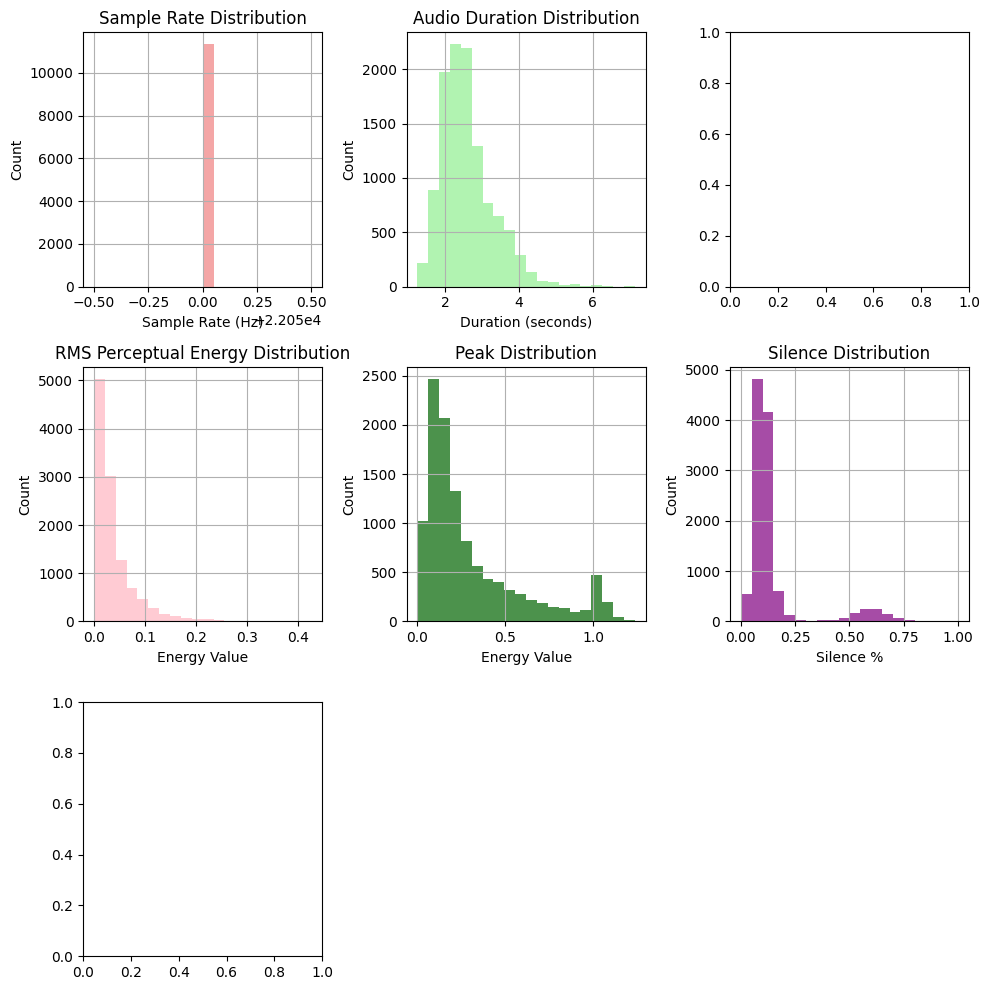

In [27]:
sr_df, invalid_files = get_info(audios)

Removing -inf loudness files

In [28]:
loudness = sr_df.loudness
loudness.describe()
loudness.argmax()
loudness.argmin()

/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


np.int64(1730)

In [29]:
loudness.sort_values(ascending=True).head(10)

1730         -inf
8204   -61.197584
8220   -60.653319
8461   -59.933696
8211   -58.522649
8190   -57.074987
8459   -56.672095
8456   -56.544329
8205   -56.142881
8010   -56.058861
Name: loudness, dtype: float64

there is 1 file with -inf loudness, let's take a look at that, and remove it if necessary

In [30]:
inf_loudness = sr_df[sr_df.loudness == -np.inf]

for _, row in inf_loudness.iterrows():
    print("ID:", row.ID)
    ipd.display(ipd.Audio(filename=row.path, rate=row.sample_rate))

ID: 1730


this file has absolutely no spoken data in them, we'll remove this file

In [31]:
audios.drop(inf_loudness.ID, axis=0, inplace=True)

Verifying audio files...


Checking audio files:  71%|███████   | 8056/11324 [00:17<00:07, 450.24it/s]/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Checking audio files: 100%|██████████| 11324/11324 [00:25<00:00, 446.15it/s]


 Valid files: 11324
 Invalid files: 0
Length of DataFrame: 11324


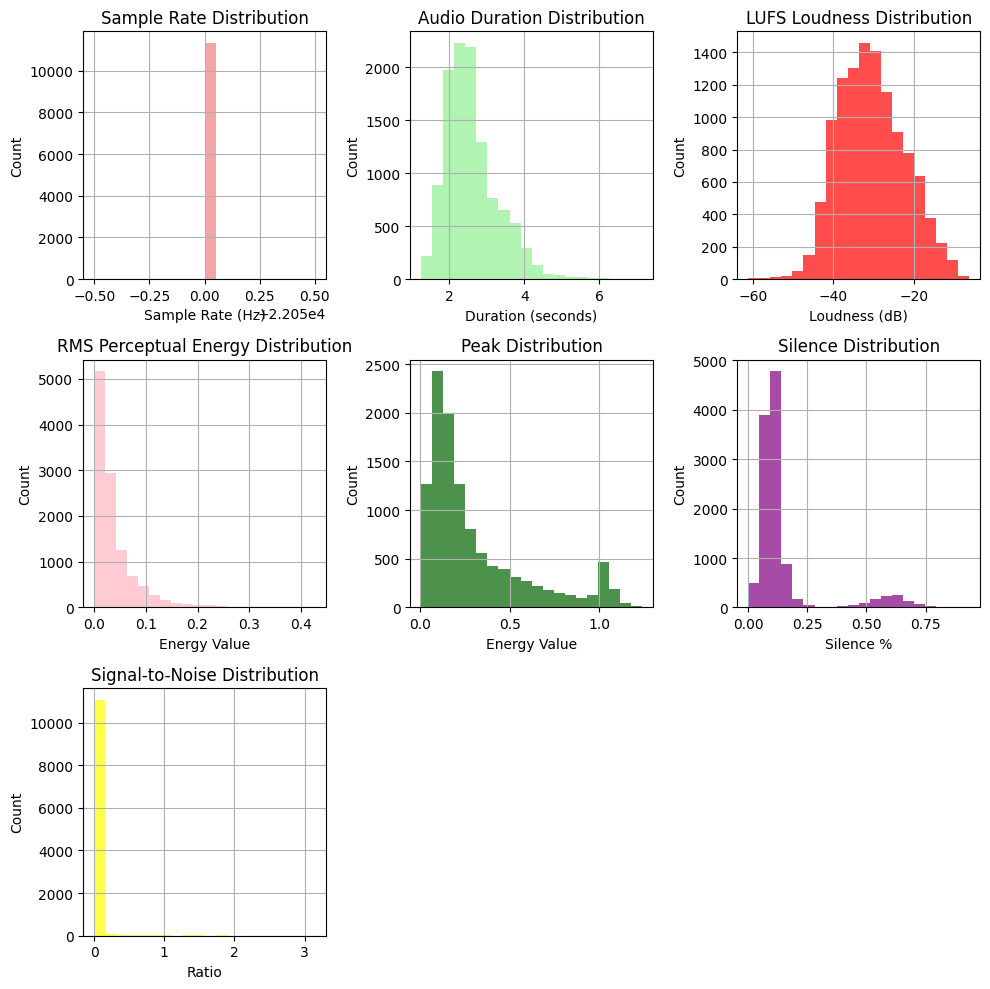

In [32]:
# Re-verify the files
sr_df, invalid_files = get_info(audios)

In [33]:
sr_df[['signal_to_noise', 'sample_rate', 'loudness', 'peak', 'rms']].describe().T

count          mean       std           min           25%  \
signal_to_noise  11324.0      0.023397  0.185826     -0.000010      0.000001   
sample_rate      11324.0  22050.000000  0.000000  22050.000000  22050.000000   
loudness         11324.0    -30.496083  8.180941    -61.197584    -36.687737   
peak             11324.0      0.303259  0.281853      0.006039      0.106586   
rms              11324.0      0.040088  0.043606      0.000650      0.013823   

                          50%           75%           max  
signal_to_noise      0.000004      0.000020      3.145864  
sample_rate      22050.000000  22050.000000  22050.000000  
loudness           -31.076588    -24.808545     -6.270643  
peak                 0.189790      0.402890      1.237764  
rms                  0.024143      0.049009      0.426356

 From the RMS and peak value statistics, it seems like there are some almost silent files as well.

In [34]:
import time

In [35]:
lowest_rms = sr_df.sort_values(by='rms', ascending=True)

for idx, row in lowest_rms.head(10).iterrows():
    print(f"Dataset: {row.dataset}; Emotion: {row.emotion}; loudness: {row.loudness:.6f}; peak: {row.peak:.6f}; rms: {row.rms:.6f}")
    ipd.display(ipd.Audio(filename=row.path, rate=row.sample_rate, autoplay=True))
    time.sleep(row.duration+1)
    #ipd.clear_output()

Dataset: RAVDESS; Emotion: Sad; loudness: -61.197584; peak: 0.008141; rms: 0.000650


Dataset: RAVDESS; Emotion: Sad; loudness: -60.653319; peak: 0.006039; rms: 0.000667


Dataset: RAVDESS; Emotion: Sad; loudness: -59.933696; peak: 0.006117; rms: 0.000690


Dataset: RAVDESS; Emotion: Sad; loudness: -57.074987; peak: 0.012595; rms: 0.000786


Dataset: RAVDESS; Emotion: Fearful; loudness: -58.522649; peak: 0.013602; rms: 0.000840


Dataset: RAVDESS; Emotion: Sad; loudness: -56.672095; peak: 0.008316; rms: 0.000949


Dataset: RAVDESS; Emotion: Sad; loudness: -56.544329; peak: 0.008702; rms: 0.000985


Dataset: RAVDESS; Emotion: Fearful; loudness: -55.893755; peak: 0.009155; rms: 0.001134


Dataset: RAVDESS; Emotion: Sad; loudness: -54.572314; peak: 0.013724; rms: 0.001142


Dataset: RAVDESS; Emotion: Fearful; loudness: -56.142881; peak: 0.012002; rms: 0.001183


Low RMS values will also have low peaks and low loudness since RMS, peak and loudness are correlated

## Normalization & Standardization

In [36]:
TARGET_DBFS = -20.0

def normalize_loudness(audio_path, target_dBFS=TARGET_DBFS):
    #Step1: Load the audio
    audio_data, sr = torchaudio.load(audio_path)

    # Step2:  Calculate the RMS of the audio
    rms = torch.sqrt(torch.mean(audio_data**2))

    #Step3: Handle Silence
    if rms == 0:
       return audio_data

    #Step4: Convert RMS to dBFS (logarithmic scale relative to the max digital value(1,0))
    current_dBFS = 20 * torch.log10(rms)

    #Step5: Calculate the gain needed (positive value: increase, negative value: decresase loudness)
    gain_dB = target_dBFS - current_dBFS

    #Step6: Convert gain from dB to linear scale ( since audio is stored as linear amplitude not dB)
    gain_linear = 10 ** (gain_dB / 20)

    #Step7: Apply the gain to the audio data
    normalized_audio = audio_data * gain_linear

    new_peak = torch.max(torch.abs(normalized_audio))
    new_rms = torch.sqrt(torch.mean(normalized_audio**2))

    return normalized_audio, sr, new_rms.item(), new_peak.item()

In [37]:
for idx, row in lowest_rms.head(10).iterrows():
    ipd.clear_output()

    wave, sr, rms, peak = normalize_loudness(row.path)

    print(f"Dataset: {row.dataset}; Emotion: {row.emotion}")
    print(f"Old RMS: {row.rms}; New RMS: {rms}")
    print(f"Old peak: {row.peak}; New peak: {peak}")

    ipd.display(ipd.Audio(wave, rate=sr, autoplay=True))
    time.sleep(row.duration+1)

# Then the ones that had a relatively lower RMS
for idx, row in lowest_rms.head(50).tail(10).iterrows():
    ipd.clear_output()

    wave, sr, rms, peak = normalize_loudness(row.path)

    print(f"Dataset: {row.dataset}; Emotion: {row.emotion}")
    print(f"Old RMS: {row.rms}; New RMS: {rms}")
    print(f"Old peak: {row.peak}; New peak: {peak}")
    ipd.display(ipd.Audio(wave, rate=sr, autoplay=True))
    time.sleep(row.duration+1)

Dataset: RAVDESS; Emotion: Sad
Old RMS: 0.0024754127953201532; New RMS: 0.09999997913837433
Old peak: 0.02175191044807434; New peak: 0.8772530555725098


In [38]:
loudness_below_60dB = lowest_rms[lowest_rms.loudness < -60]

print("Number of files we're removing: ", loudness_below_60dB.shape[0])
print("\nDatasets from which we're removing files: ", dict(loudness_below_60dB.dataset.value_counts()))
print("\nEmotions from which we're removing files: ", dict(loudness_below_60dB.emotion.value_counts()))

Number of files we're removing:  2

Datasets from which we're removing files:  {'RAVDESS': np.int64(2)}

Emotions from which we're removing files:  {'Sad': np.int64(2)}


Verifying audio files...


Checking audio files: 100%|██████████| 11322/11322 [00:23<00:00, 483.55it/s]


 Valid files: 11322
 Invalid files: 0
Length of DataFrame: 11322


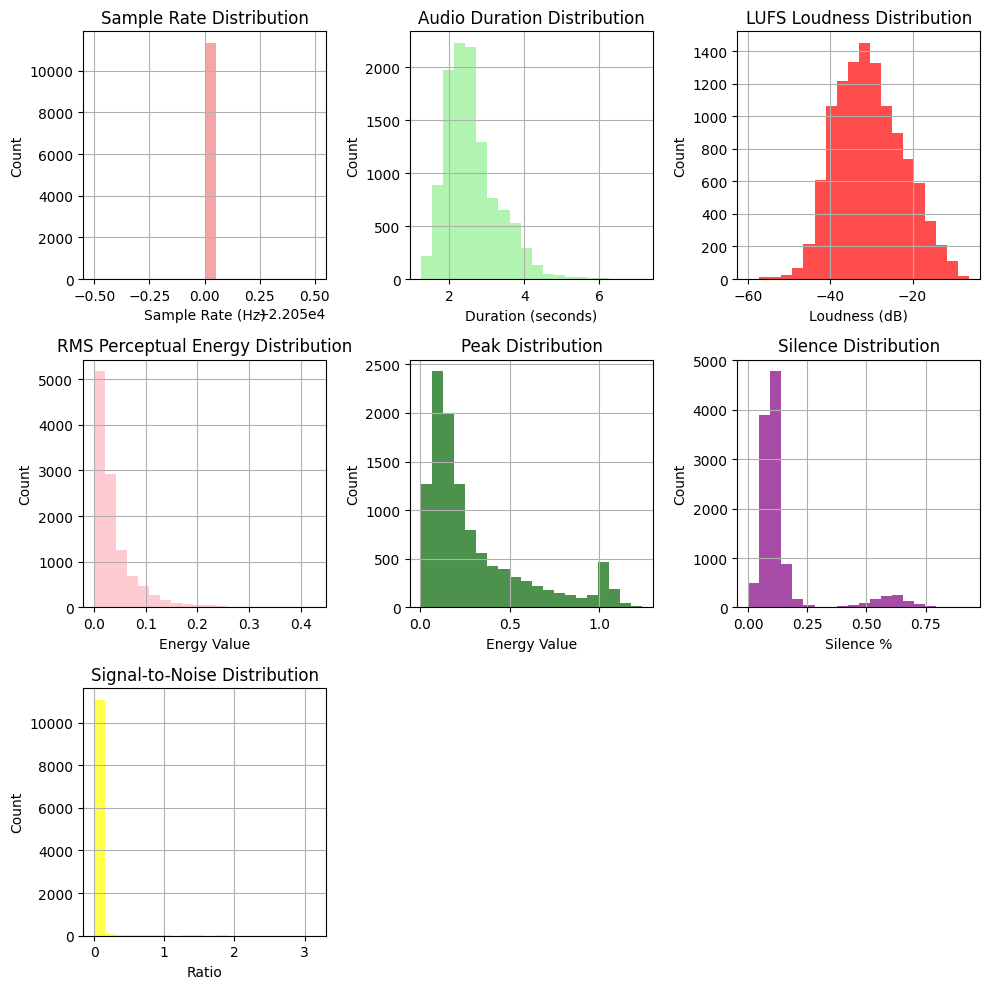

In [39]:
audios.drop(list(loudness_below_60dB.ID), axis=0, inplace=True)

# Again re-verify the files
sr_df, invalid_files = get_info(audios)

In [40]:
sr_df.loudness.min()

np.float64(-59.93369576967618)

In [41]:
sr_df.rms.min()

np.float32(0.0006901626)

In [42]:
sr_df.peak.min()

np.float32(0.006117357)

Plot distributions

In [43]:
durations = sr_df.duration.round()
durations.value_counts().sort_index()

duration
1.0     121
2.0    5747
3.0    4052
4.0    1247
5.0     118
6.0      34
7.0       3
Name: count, dtype: int64

In [44]:
durations.round().describe()

count    11322.000000
mean         2.612083
std          0.763552
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: duration, dtype: float64

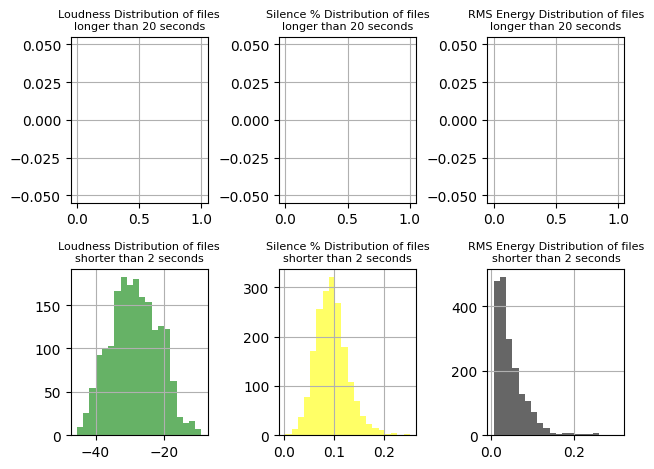

In [45]:
plt.subplot(2, 3, 1)
sr_df[(sr_df.duration > 20.0)]['loudness'].hist(bins=20, alpha=0.6, color='red')
plt.title("Loudness Distribution of files\nlonger than 20 seconds", fontsize=8)

plt.subplot(2, 3, 2)
sr_df[(sr_df.duration > 20.0)]['silence_pct'].hist(bins=20, alpha=0.6, color='blue')
plt.title("Silence % Distribution of files\nlonger than 20 seconds", fontsize=8)

plt.subplot(2, 3, 3)
sr_df[(sr_df.duration > 20.0)]['rms'].hist(bins=20, alpha=0.6, color='gray')
plt.title("RMS Energy Distribution of files\nlonger than 20 seconds", fontsize=8)

plt.subplot(2, 3, 4)
sr_df[(sr_df.duration < 2.0)]['loudness'].hist(bins=20, alpha=0.6, color='green')
plt.title("Loudness Distribution of files\nshorter than 2 seconds", fontsize=8)

plt.subplot(2, 3, 5)
sr_df[(sr_df.duration < 2.0)]['silence_pct'].hist(bins=20, alpha=0.6, color='yellow')
plt.title("Silence % Distribution of files\nshorter than 2 seconds", fontsize=8)

plt.subplot(2, 3, 6)
sr_df[(sr_df.duration < 2.0)]['rms'].hist(bins=20, alpha=0.6, color='black')
plt.title("RMS Energy Distribution of files\nshorter than 2 seconds", fontsize=8)

plt.tight_layout()
plt.show()

In [46]:
ds_df = sr_df.groupby('dataset')
ds_df["duration"].describe()

count      mean       std       min       25%       50%       75%  \
dataset                                                                       
CREMA-D  7441.0  2.542907  0.506014  1.267982  2.202222  2.502540  2.836190   
RAVDESS  1061.0  3.723126  0.336019  3.069751  3.503537  3.670340  3.903900   
SAVEE     420.0  3.844676  1.076625  1.630930  3.086735  3.672993  4.524184   
TESS     2400.0  2.063040  0.338072  1.254104  1.819853  2.066689  2.313469   

              max  
dataset            
CREMA-D  5.005034  
RAVDESS  5.271973  
SAVEE    7.138730  
TESS     2.984807

Getting the Emotion Distribution by Dataset

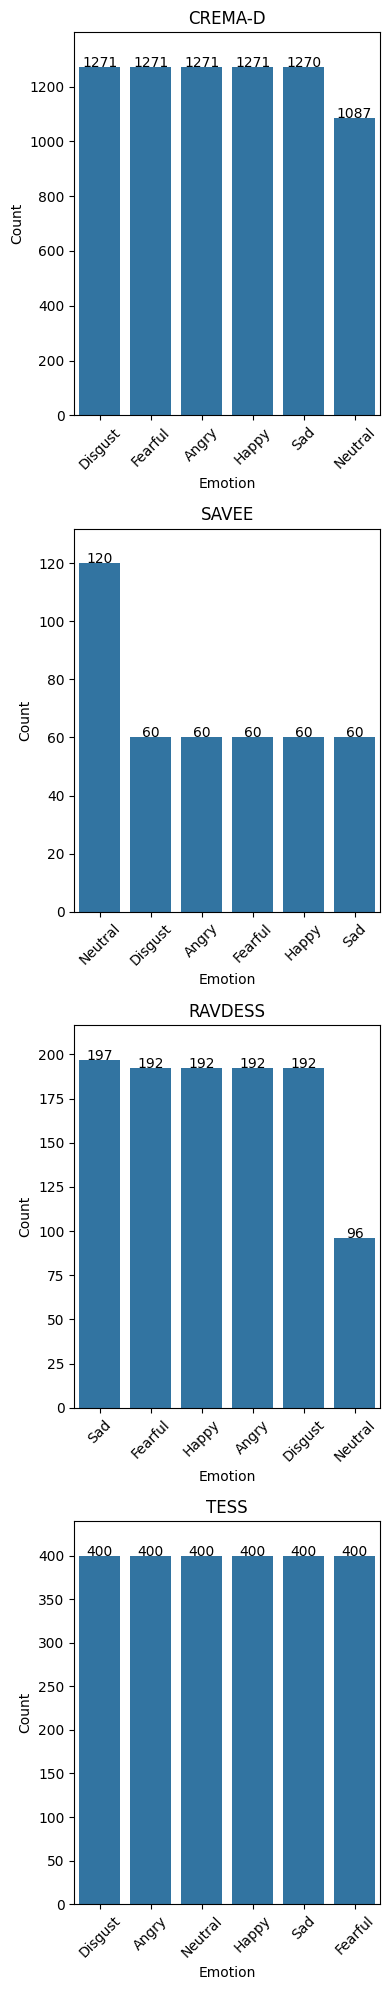

In [47]:
num_datasets = len(sr_df.dataset.unique())
fig, axes = plt.subplots(nrows=num_datasets, ncols=1, figsize=(num_datasets, 20))

axes = axes.flatten()

# Loop through each dataset and plot
for ax, dataset in zip(axes, sr_df.dataset.unique()):
    subset = sr_df[sr_df['dataset'] == dataset]
    sns.countplot(data=subset, x='emotion', ax=ax, order=subset['emotion'].value_counts().index)
    ax.set_title(f"{dataset}")
    ax.set_xlabel("Emotion")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(0, subset['emotion'].value_counts().max() * 1.1)

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 0.05, int(height), ha="center", fontsize=10)


plt.tight_layout()
plt.show()

Get the overall stats of all the features by the datasets

In [48]:
ds_df[['duration', 'loudness', 'rms', 'silence_pct', 'signal_to_noise']].describe(percentiles=[]).T

dataset                    CREMA-D      RAVDESS       SAVEE         TESS
duration        count  7441.000000  1061.000000  420.000000  2400.000000
                mean      2.542907     3.723126    3.844676     2.063040
                std       0.506014     0.336019    1.076625     0.338072
                min       1.267982     3.069751    1.630930     1.254104
                50%       2.502540     3.670340    3.672993     2.066689
                max       5.005034     5.271973    7.138730     2.984807
loudness        count  7441.000000  1061.000000  420.000000  2400.000000
                mean    -30.557020   -35.283435  -23.461047   -29.396519
                std       8.098253     9.130890   10.780546     5.879830
                min     -49.054815   -59.933696  -46.484189   -41.502656
                50%     -31.420584   -35.853245  -20.761944   -29.715099
                max      -8.447171   -13.387512   -6.270643   -16.170895
rms             count  7441.000000  1061.000000  420.000000  2400.000000
                mean      0.039100     0.021081    0.112148     0.038975
                std       0.042364     0.024868    0.090365     0.025193
                min       0.003735     0.000690    0.004910     0.008511
                50%       0.022622     0.011459    0.092424     0.031465
                max       0.303491     0.152070    0.426356     0.140778
silence_pct     count  7441.000000  1061.000000  420.000000  2400.000000
                mean      0.100662     0.592276    0.023068     0.116830
                std       0.025976     0.097199    0.036238     0.045554
                min       0.030044     0.226135    0.001289     0.018997
                50%       0.098852     0.595943    0.003604     0.111883
                max       0.359729     0.933585    0.125290     0.323777
signal_to_noise count  7441.000000  1061.000000  420.000000  2400.000000
                mean      0.000018     0.000020    0.630320     0.000024
                std       0.000036     0.000212    0.741424     0.000080
                min      -0.000001    -0.000009    0.004867    -0.000001
                50%       0.000005     0.000000    0.273852     0.000004
                max       0.000621     0.005464    3.145864     0.002250

# Preprocessing the files in DataFrame

 We need to store them as Tensor files of 5 second audio chunks, sampled at 22.5kHz so each tensor will have a shape of (1, 22050*5)

In [53]:
TARGET_SR = 22050
TARGET_RMS = 0.03
MAX_PEAK = 0.99
DURATION = 5.0
TARGET_dBFS = -23.0
NUM_SAMPLES = int(TARGET_SR * DURATION)
MIN_SAMPLES = TARGET_SR * 2
OUTPUT_DIR = "/content/drive/MyDrive/Datasets/Processed_Audio"

os.makedirs(OUTPUT_DIR, exist_ok=True)

def normalize_audio(audio_data, target_dBFS=TARGET_dBFS):
  # Calculate the RMS of the audio
    rms = torch.sqrt(torch.mean(audio_data**2))
     # Avoid division by zero in case of a completely silent audio
    if rms == 0: return audio_data
     # Convert RMS to dBFS
    current_dBFS = 20 * torch.log10(rms)
    # Calculate the required gain in dB
    gain_dB = target_dBFS - current_dBFS
    # Convert gain from dB to linear scale
    gain_linear = 10 ** (gain_dB / 20)
    # Apply the gain to the audio data
    normalized_audio = audio_data * gain_linear

    return normalized_audio

# Worker function for each file
def process_row(idx, row):
    path = row['Path']
    dataset = row["Dataset"]
    emotion = row['Emotion']
    filename = row['File']
    local_results = []

    try:
        wave, sr = torchaudio.load(path)

        # Normalize Sample Rate
        if sr != TARGET_SR:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=TARGET_SR)
            wave = resampler(wave)

        # Convert to mono channel
        if wave.shape[0] > 1:
            wave = torch.mean(wave, dim=0, keepdim=True)

        # Right pad if length less than expected duration
        if wave.shape[1] < NUM_SAMPLES:
            padding = NUM_SAMPLES - wave.shape[1]
            wave = F.pad(wave, (0, padding))

        # Center truncate if length greater than expected duration
        if wave.shape[1] > NUM_SAMPLES:
            start = (wave.shape[1] - NUM_SAMPLES) // 2
            end = (wave.shape[1] + NUM_SAMPLES) // 2
            wave = wave[:, start:end]

        # Normalize the loudness of the wave
        wave = normalize_audio(wave)

        save_dir = os.path.join(OUTPUT_DIR, dataset, emotion)
        os.makedirs(save_dir, exist_ok=True)

        output_path = os.path.join(save_dir, f"{filename}.pt")
        torch.save(wave, output_path)

        local_results.append({
            'Dataset': dataset,
            'Emotion': emotion,
            'File': filename
        })

    except Exception as e:
        print(f"Error processing {path}: {e}")
        raise Exception(str(e))

    return local_results

results = Parallel(n_jobs=-1, verbose=5)(
    delayed(process_row)(idx, row) for idx, row in audios.iterrows()
)

flattened = [item for sublist in results for item in sublist]
saved_files = pd.DataFrame(flattened)

print(f"Preprocessing complete! Total chunks: {len(saved_files)}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 516 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 1020 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 1668 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 2460 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 3396 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 4396 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 5540 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6868 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 8380 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 9232 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 9682 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 10168 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 10690 tasks     

Preprocessing complete! Total chunks: 11322


[Parallel(n_jobs=-1)]: Done 11322 out of 11322 | elapsed: 11.8min finished


# Saving Files

In [50]:
saved_files.to_csv("saved_files.csv", index=False, columns=['Dataset', "Emotion", "File"])
saved_files

Dataset  Emotion             File
0      CREMA-D  Disgust  1079_IWW_DIS_XX
1      CREMA-D  Disgust  1079_TIE_DIS_XX
2      CREMA-D  Fearful  1080_IOM_FEA_XX
3      CREMA-D  Neutral  1080_TAI_NEU_XX
4      CREMA-D      Sad  1079_TAI_SAD_XX
...        ...      ...              ...
11317     TESS      Sad     YAF_time_sad
11318     TESS      Sad    YAF_thumb_sad
11319     TESS      Sad     YAF_wash_sad
11320     TESS      Sad     YAF_whip_sad
11321     TESS      Sad     YAF_walk_sad

[11322 rows x 3 columns]

In [51]:
drive_path = "/content/drive/MyDrive/Datasets"
saved_files.to_csv(f"{drive_path}/saved_files.csv", index=False, columns=['Dataset', "Emotion", "File"])


In [54]:
CSV_PATH="/content/drive/MyDrive/Datasets/saved_files.csv"

In [55]:
def preprocess_missing_audio(audios_df):
    print("Checking for missing .pt files...")

    # Build expected path column
    audios_df["ExpectedPath"] = audios_df.apply(
        lambda row: f"{OUTPUT_DIR}/{row['Dataset']}/{row['Emotion']}/{row['File']}.pt", axis=1
    )

    audios_missing = audios_df[~audios_df["ExpectedPath"].apply(os.path.exists)].reset_index(drop=True)
    print(f"Files to process: {len(audios_missing)}")

    if len(audios_missing) == 0:
        print("✅ All files already processed. Nothing to do.")
        return

    # Process in parallel
    results = Parallel(n_jobs=-1, verbose=5)(
        delayed(process_row)(idx, row) for idx, row in audios_missing.iterrows()
    )

    # Filter out any failures
    processed = [r for r in results if r]
    saved_files_new = pd.DataFrame(processed)

    # Merge with old saved_files.csv
    if os.path.exists(CSV_PATH):
        saved_files_old = pd.read_csv(CSV_PATH)
        saved_files_combined = pd.concat([saved_files_old, saved_files_new]).drop_duplicates()
    else:
        saved_files_combined = saved_files_new

    saved_files_combined.to_csv(CSV_PATH, index=False)
    print(f"✅ Done. Total saved files: {len(saved_files_combined)}")

In [56]:
preprocess_missing_audio(audios)

Checking for missing .pt files...
Files to process: 0
✅ All files already processed. Nothing to do.
